In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 15
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

In [3]:
movies = pd.read_csv('movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Split to train and validation
ratings = ratings.sort_values(by='timestamp', ascending=True)

train = ratings.iloc[:-20000]
test = ratings.iloc[-20000:]

In [6]:
# Double-check
train.timestamp.max() <= test.timestamp.min()

True

#### User-based collaborative filtering

1) $$ rating(user_k, item_m) = r_k^{mean} + \frac{\sum_{user_i \in U(user_k)}{(r_{user_i}(item_m) - r_{user_i}^{mean}) \cdot sim(user_k, user_i)}}{\sum_{user_i \in U(user_k)}{|sim(user_k, user_i)|}}$$

2) $$ rating(user_k, item_m) = \frac{\sum_{user_i \in U(user_k)}{r_{user_i}(item_m) \cdot sim(user_k, user_i)}}{\sum_{user_i \in U(user_k)}{|sim(user_k, user_i)|}}$$

In [37]:
pivot = train.pivot_table(index='movieId', columns='userId', values='rating')
# pivot = pivot.astype(pd.SparseDtype("float64",0))

pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,604,605,606,607,608,609
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,2.5,NaN,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [29]:
pivot.shape

(7867, 522)

In [33]:
# pivot = pivot.sparse.to_coo().tocsr()

# pivot.shape

(7867, 522)

In [22]:
# from scipy.sparse import csr_matrix

# pivot = csr_matrix(pivot.values)

# pivot.shape

In [38]:
# Subtract mean user ratings to make users' ratings more similar
pivot = pivot.subtract(pivot.mean(axis=1), axis='rows')

pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,604,605,606,607,608,609
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.076087,NaN,NaN,NaN,0.076087,NaN,0.576087,NaN,NaN,NaN,...,-1.423913,NaN,NaN,0.076087,-0.923913,0.076087,-1.423913,0.076087,-1.423913,-0.923913
2,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,0.6,NaN,NaN,...,0.600000,NaN,0.6,NaN,1.600000,0.100000,NaN,NaN,-1.400000,NaN
3,0.705882,NaN,NaN,NaN,NaN,1.705882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.294118,NaN
4,NaN,NaN,NaN,NaN,NaN,0.642857,NaN,NaN,NaN,NaN,...,-0.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.936170,NaN,NaN,NaN,NaN,...,-0.563830,NaN,NaN,NaN,-0.063830,NaN,NaN,NaN,NaN,NaN


In [39]:
# Use non-linear correlation do detect more complex similarities
corrs = pivot.corr('spearman')

# Or use Pearson (Cosine similarity) instead
# corrs = pivot.corr()

corrs.head()

userId,1,2,3,4,5,6,7,8,9,10,...,600,601,602,603,604,605,606,607,608,609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.0,0.321429,0.235441,0.203297,-0.309492,-0.158291,0.457143,1.0,0.371429,...,0.042989,0.0,-0.054945,-0.159832,-0.335664,-0.200392,-0.052775,0.103087,-0.070424,0.350000
2,1.000000,1.0,NaN,NaN,NaN,1.000000,0.500000,NaN,NaN,0.100000,...,0.500000,0.5,NaN,-1.000000,NaN,NaN,0.700000,NaN,0.542857,NaN
3,0.321429,NaN,1.000000,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,...,0.033333,NaN,-1.000000,0.183333,NaN,NaN,-0.547619,-0.200000,-0.100000,NaN
4,0.235441,NaN,NaN,1.000000,-0.650350,-0.071145,0.374365,-0.050000,NaN,0.483333,...,-0.015564,-0.4,0.265810,-0.042880,-0.166667,0.232353,0.039095,0.026108,-0.365302,0.500000
5,0.203297,NaN,NaN,-0.650350,1.000000,0.016988,0.033333,-0.242105,NaN,-0.500000,...,0.149973,1.0,0.052823,0.131538,-0.156140,-0.226374,0.055336,-0.100000,-0.201780,0.333333


In [40]:
corrs = corrs.unstack().rename_axis(['userId1', 'userId2']).reset_index()
corrs.columns = ['userId1', 'userId2', 'correlation']

corrs.head()

,userId1,userId2,correlation
0,1,1,1.000000
1,1,2,1.000000
2,1,3,0.321429
3,1,4,0.235441
4,1,5,0.203297


In [41]:
corrs.shape

(272484, 3)

In [42]:
# Leave only valid user-user pairs with positive correlation
pos_corrs = corrs[(corrs.correlation > 0) & (corrs.userId1 != corrs.userId2)]

pos_corrs.head()

,userId1,userId2,correlation
1,1,2,1.000000
2,1,3,0.321429
3,1,4,0.235441
4,1,5,0.203297
7,1,8,0.457143


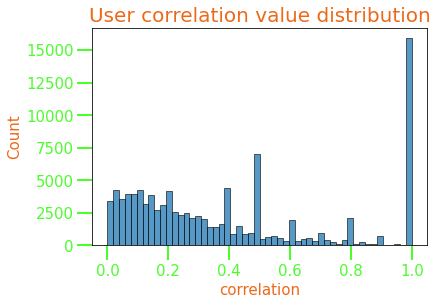

In [43]:
sns.histplot(pos_corrs.correlation)

plt.title('User correlation value distribution')
plt.show()

There is a huge peak at **1** correlation, which may be due to users without any similaties (NaN values), so we may want to drop such correlations

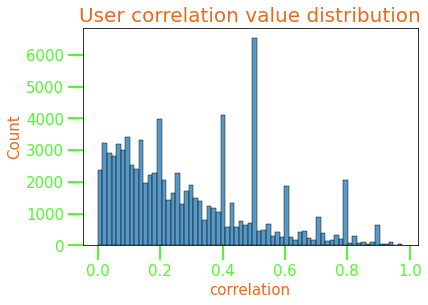

In [54]:
pos_corrs = pos_corrs[pos_corrs.correlation < 1]

sns.histplot(pos_corrs.correlation)

plt.title('User correlation value distribution')
plt.show()

In [51]:
print('Mode:\t', pos_corrs.correlation.mode())

Mode:	 0    0.5
Name: correlation, dtype: float64


Mode of **0.5** correlation kinda makes sense

In [56]:
# Get k-neighborhood of users who rated the chosen item 
def get_n_similar_users(user_id, item_id,
                        n_neighbors=5, similarity_threshold=0.3) -> [np.array, np.array]:
    
    neighbors = pos_corrs[pos_corrs.userId1 == user_id] \
                .sort_values(by='correlation', ascending=False) # All neighbours  
    
    # Filter those who haven' watched the movie
    valid_neighbors = np.intersect1d(
        neighbors, ratings[ratings.movieId == item_id].userId
    )
    n_rates = neighbors[neighbors.userId2.isin(valid_neighbors)] 

    # Get most valid users
    n_rates = n_rates[n_rates.correlation >= similarity_threshold]
    
    # Can still return less than k users (-_-)
    if n_rates.shape[0] < n_neighbors:
        n_rates = pd.concat(
            (n_rates, 
             neighbors[~neighbors.userId2.isin(valid_neighbors)]),
            axis=0
        )
        
    return np.array(n_rates.head(n_neighbors).userId2), \
            np.array(n_rates.head(n_neighbors).correlation)


# Predict item rating by user and 
def item_rating_prediction(user_id, item_id, 
                           neighbor_ids, neighbor_weights) -> float:
    
    mean_rating = ratings[ratings.userId == user_id].rating.mean()
    neighbor_means = np.array([ratings[ratings.userId == id_].rating.mean() for id_ in neighbor_ids])
    
    neighbor_ratings = []
    for i, id_ in enumerate(neighbor_ids):
        df = ratings[(ratings.userId == id_) & (ratings.movieId == item_id)]
        
        if df.size != 0:
            neighbor_ratings.append(df.iloc[0].rating)
        else:
            neighbor_ratings.append(neighbor_means[i])
            
    neighbor_ratings = np.array(neighbor_ratings)

    if neighbor_ratings.size == 0:
        return mean_rating
    
    # 1st method
    return mean_rating + np.sum(neighbor_weights * (neighbor_ratings - neighbor_means)) \
            / np.sum(np.abs(neighbor_weights))

    # 2nd method
#     return np.sum(neighbor_weights * neighbor_ratings) / np.sum(np.abs(neighbor_weights))


def make_single_prediction(user_id, item_id, n_neighbors=10
                           , similarity_threshold=0.3) -> [float, float]:
    
    neighbor_ids, neighbor_weights = get_n_similar_users(user_id, item_id, n_neighbors
                                                         , similarity_threshold)
    
    return item_id, item_rating_prediction(user_id, item_id, neighbor_ids, neighbor_weights)

    
def make_prediction(user_id, n_movies, movie_sample_size=500,
                    n_neighbors=50, similarity_threshold=0.3, rec_threshold=3.5):
    
    items_to_recommend = np.array([])
    ratings = np.array([])
    for item_id in movies.sample(movie_sample_size).movieId:
        pred = make_single_prediction(200, item_id, n_neighbors=10)
        
        if pred[1] >= rec_threshold:
            items_to_recommend = np.append(items_to_recommend, pred[0])
            ratings = np.append(ratings, pred[1])
    
    items_to_recommend = items_to_recommend[np.argsort(-ratings)]
    ratings.sort()
    
    return items_to_recommend[:n_movies], ratings[::-1][:n_movies]

In [57]:
make_single_prediction(200, 10, n_neighbors=10)

(10, 3.8431212444723815)

In [59]:
make_prediction(120, 10, 1000, rec_threshold=4)

(array([ 110.,  318., 3421., 1194., 1663., 2716.,  589., 1247., 7361.,
        3072.]),
 array([4.86264751, 4.44754834, 4.10196814, 4.10196814, 4.10196814,
        4.09234392, 4.07006559, 4.04367735, 4.02287638, 4.01133825]))

In [60]:
make_prediction(120, 10, 1000, rec_threshold=4)

(array([  733.,   457.,   161.,   165.,  1221., 46578.,  5014.,  5618.,
         2907.,   778.]),
 array([4.39524528, 4.28435132, 4.27979329, 4.09200421, 4.08147619,
        4.07141533, 4.04603446, 4.0389619 , 4.02678854, 4.00240311]))

In [61]:
from sklearn.metrics import mean_squared_error

predictions = []

for i, row in test.iterrows():
    predictions.append(make_single_prediction(row.userId, row.movieId)[1])
    
print(mean_squared_error(test.rating, predictions, squared=False))

0.9039207189184608


In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

real_int = test.rating >= 3.5
pred_int = np.array(predictions) >= 3.5

print('Accuracy:\t', accuracy_score(real_int, pred_int))
print('Precision:\t', precision_score(real_int, pred_int))
print('Recall:\t', recall_score(real_int, pred_int))
print('F1-score:\t', f1_score(real_int, pred_int))

Accuracy:	 0.7037
Precision:	 0.7736810292720836
Recall:	 0.7305340399510803
F1-score:	 0.75148871928206


PR-AUC:	 0.8347325346115819


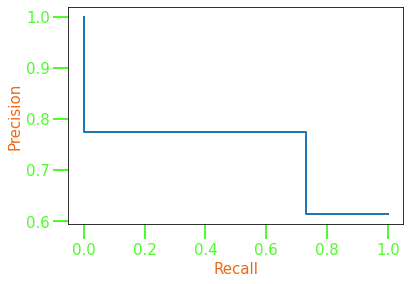

In [63]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc

pr, rec, thr = precision_recall_curve(real_int, pred_int)

print('PR-AUC:\t', auc(rec, pr))

PrecisionRecallDisplay(precision=pr, recall=rec).plot()

# plt.ylim(0, 1)
# plt.xlim(0, 1)

plt.show()

This is a slight PR-AUC improvement 

#### Item-item

Абсолютно аналогично User-user

1) $$ rating(item_k, user_m) = r_k^{mean} + \frac{\sum_{item_i \in I(item_k)}{(r_{user_m}(item_i) - r_{item_i}^{mean}) \cdot sim(item_k, item_i)}}{\sum_{item_i \in I(item_k)}{|sim(item_k, item_i)|}}$$

2) $$ rating(item_k, user_m) = \frac{\sum_{item_i \in I(item_k)}{r_{user_m}(item_i) \cdot sim(item_k, item_i)}}{\sum_{item_i \in I(item_k)}{|sim(item_k, item_i)|}}$$

In [ ]:
pivot = ratings.pivot_table(index='userId', columns='movieId', values='rating')

pivot.head()

In [ ]:
pivot.shape

In [ ]:
corrs = pivot.corr()

corrs.head()

In [ ]:
corrs = corrs.unstack().rename_axis(['movieId1', 'movieId2']).reset_index()
corrs.columns = ['movieId1', 'movieId2', 'rating']

corrs.head()

Все последующие шаги аналогичны **User-user** фильтрации

### Alternating least squares (ALS)

Идея: хотим кодировать каждого юзера и товар в векторы $p_i$ и $q_j$ длины *m* так, чтобы $$ <p_i \cdot q_j> = r_{p_i}(q_j) $$

Также мы знаем матрицу *R* (история оценок пользователей)
$$ P^T \cdot Q \approx R$$  

Тогда хотим минимизизировать ошибку:

$$\sum_{u, i: \quad r_u{i} \in R} (r_u{i} - b_u - b_i - < p_u \cdot q_i>)^2 \rightarrow \min_{b_u, b_i, p_u, p_i}$$

* К ней еще можно добавить регуляризацию

То есть проходим по всем парам пользователь-товар, для которых есть оценка и далее минимизируем такую сумму квадратов, где $b_u$ и $b_i$ - это свободные члены (свои для каждого пользователя и каждого товара) 



Такая функция - это резня. Довольно много параметров и экстремумов

1. Можно попробовать привычным градиентным спуском - например, стохастическим (на практике результат плохой из-за большого числа экстремумов)
2. А можно **ALS**

#### Алгоритм ALS
1. Инициализация матриц *P, Q*
2. Фиксируем эмбеддинги одной из матриц - например, P 

    То есть в функционал ошибки пойдут просто числа из p_u 
<!--     (свободные коэффициенты все так же изменяются) -->
    
    Минимизируем получившийся функционал ошибки и получаем локальный оптимум для q_i
3. Фиксируем другую матрицу - делаем то же
4. Повторяем до критерия останова
    

In [ ]:
!pip install implicit

In [ ]:
ratings_ = ratings.drop('timestamp', axis=1)

print(csr_matrix(ratings_)[0])

In [ ]:
!export MKL_NUM_THREADS=1

In [ ]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=5)
data = csr_matrix(ratings_)

# model.fit(data)

# user_items = item_user_data.T.tocsr()
# recommendations = model.recommend(userid, user_items)

# # find related items
# related = model.similar_items(itemid)

In [ ]:
model.fit(data)